<div dir="rtl" align="center">
    <h2><strong> HW4: TimeSerie Forcasting with LSTM </strong></h2>
</div>

In [ ]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns


from torch import nn
from torchvision import transforms
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### **Load Flights Dataset from `Seaborn` library**

In [ ]:
flight_data = sns.load_dataset("flights")
flight_data.head()

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


In [ ]:
data = flight_data['passengers'].values

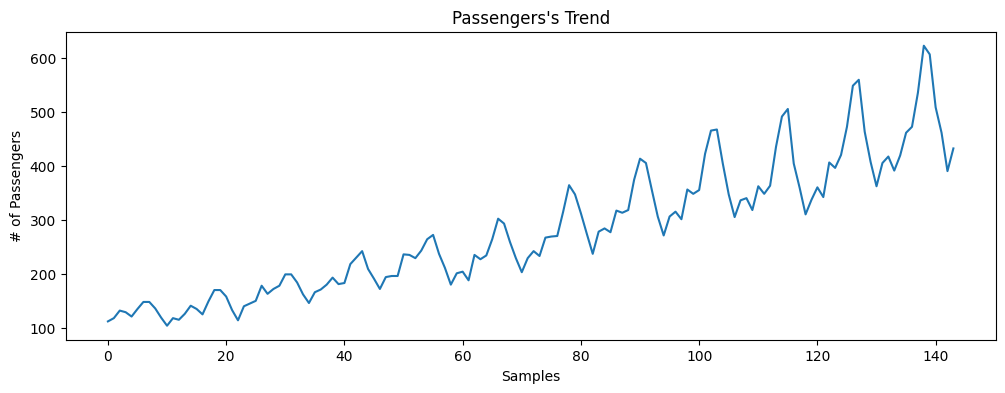

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))

_ = ax.plot(data)

_ = ax.set_title("Passengers's Trend")
_ = ax.set_xlabel("Samples")
_ = ax.set_ylabel("# of Passengers")

### **Normalize Data**

In [ ]:
scaler = MinMaxScaler(feature_range=(-1, 1))
data_normalized = scaler.fit_transform(data.reshape(-1, 1))

### **Make Sequence Data**

In [ ]:
def create_input_sequences(data: np.ndarray, window: int):
    X, labels = list(), list()
    data_size = len(data)
    for i in range(data_size - window):
        X.append(data[i:i+window])
        labels.append(data[i+window])

    X, labels = np.array(X), np.array(labels)

    return X, labels

In [ ]:
X, y = create_input_sequences(data_normalized, window=4)

In [ ]:
print(X.shape, y.shape)

(140, 4, 1) (140, 1)


### **Create Custom Dataset Torch**

In [ ]:
class SimpleDataset(Dataset):
    def __init__(self, x: np.ndarray, y: np.ndarray) -> None:
        super(SimpleDataset, self).__init__()
        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        return self.x[index], self.y[index]

### **Split Train & Test with `test_size=0.2` and `shuffle=False`**

In [66]:
# TODO: COMPLETE THIS CODE
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)

### **Make Dataset & DataLoader**

In [67]:
trainset = SimpleDataset(x_train, y_train)
testset = SimpleDataset(x_test, y_test)

trainloader = DataLoader(trainset, shuffle=False, batch_size=1)
testloader = DataLoader(testset, shuffle=False, batch_size=1)

### **Make RNN model base LSTM**

In [58]:
class CustomLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super(CustomLSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size), torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

### **Define Model, Criterion and Optimizer(SGD with lr=0.001)**

### **Training CustomLSTM**

In [69]:
model = CustomLSTM(input_size=4, hidden_layer_size=128, output_size=1).to(device)

# TODO: COMPLETE THIS CODE
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [70]:
EPOCHS = 500

model.train()
for i in range(EPOCHS):
    for seq, labels in trainloader:

        seq, labels = seq.to(device), labels.to(device)
        optimizer.zero_grad()
        model.hidden_cell = (
            torch.zeros(1, 1, model.hidden_layer_size).to(device),
            torch.zeros(1, 1, model.hidden_layer_size).to(device)
        )

        y_pred = model(seq)
        single_loss = criterion(y_pred, labels)
        single_loss.backward()
        optimizer.step()


    if (i + 1) % 50 == 0:
        print(f'epoch: {i + 1}/{EPOCHS}\tloss: {single_loss.item():10.8f}')

epoch: 50/500	loss: 0.64430439
epoch: 100/500	loss: 0.38317075
epoch: 150/500	loss: 0.21260311
epoch: 200/500	loss: 0.13497242
epoch: 250/500	loss: 0.10284703
epoch: 300/500	loss: 0.08804438
epoch: 350/500	loss: 0.07956865
epoch: 400/500	loss: 0.07349708
epoch: 450/500	loss: 0.06844112
epoch: 500/500	loss: 0.06390407


### **Evaluating CustomLSTM**

In [71]:
model.eval()
predicts = list()

for seq, labels in testloader:

    seq, labels = seq.to(device), labels.to(device)
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size).to(device),
                        torch.zeros(1, 1, model.hidden_layer_size).to(device))
        predicts.append(model(seq).item())

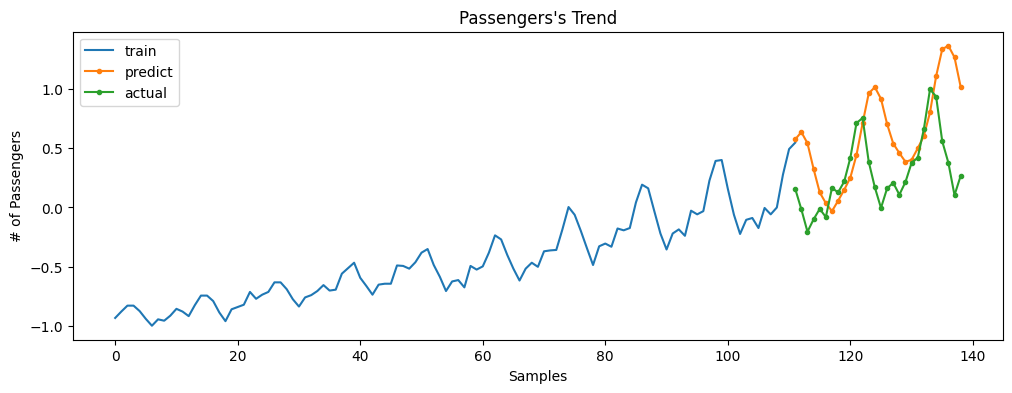

In [72]:
fig, ax = plt.subplots(figsize=(12, 4))

_ = ax.plot(y_train.flatten(), label='train')
_ = ax.plot(list(range(len(y_train.flatten())-1, data.shape[0] - 5)), predicts, marker='.', label='predict')
_ = ax.plot(list(range(len(y_train.flatten())-1, data.shape[0] - 5)), y_test.flatten(), marker='.', label='actual')

_ = ax.set_title("Passengers's Trend")
_ = ax.set_xlabel("Samples")
_ = ax.set_ylabel("# of Passengers")

_ = ax.legend()